In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
sb.set_style("white")

/tmp/6885305.1.all.q/ipykernel_24059/597048702.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
raw = ad.read_h5ad("/net/mraid14/export/tgdata/users/hernan/wd_NEW/SynEmbs3/Submission/scrna_db/iETX3.h5ad")
print(raw.shape)

(285640, 49585)


In [3]:
raw_filtered = mc.ut.slice(raw, 
    vars=["notOurs" not in name for name in raw.var.var_nms])

In [4]:
raw_filtered

AnnData object with n_obs × n_vars = 285640 × 21841
    obs: 'UMI_count', 'RT_group', 'batch', 'sample_resource', 'stage', 'condition', 'gene_count', 'doublet_score', 'EXON_pct', 'MT_pct', 'sample_ID', 'celltype'
    var: 'var_nms'

In [5]:
raw_filtered.var_names_make_unique()

In [6]:
print(raw_filtered.shape)

(285640, 21841)


In [7]:
raw = raw_filtered

In [8]:
mc.pl.analyze_clean_genes(raw,
                          excluded_gene_patterns=["Xist"],
                          random_seed=123456)

set unnamed.var[properly_sampled_gene]: 15748 true (72.1%) out of 21841 bools
set unnamed.var[excluded_gene]: 0 true (0%) out of 21841 bools
set unnamed.var[noisy_lonely_gene]: 1 true (0.004579%) out of 21841 bools


In [9]:
mc.pl.pick_clean_genes(raw)

set unnamed.var[clean_gene]: 15747 true (72.1%) out of 21841 bools


In [10]:
full = raw

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 94381 (33.04%) cells with less than 150 UMIs
Will exclude 10 (0.00%) cells with more than 1000 UMIs


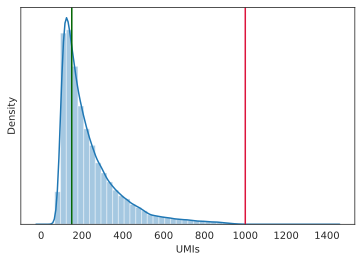

In [15]:
properly_sampled_min_cell_total = 150
properly_sampled_max_cell_total = 1000

total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

plot = sb.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 3 (0.00%) cells with more than 10.00% excluded gene UMIs


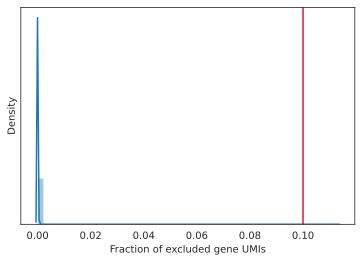

In [16]:
properly_sampled_max_excluded_genes_fraction = 0.1

excluded_genes_data = mc.tl.filter_data(full, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sb.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

In [17]:
mc.pl.analyze_clean_cells(
    full,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

set unnamed.obs[properly_sampled_cell]: 191249 true (66.95%) out of 285640 bools


In [18]:
mc.pl.pick_clean_cells(full)

set unnamed.obs[clean_cell]: 191249 true (66.95%) out of 285640 bools


In [19]:
clean = mc.pl.extract_clean_data(full)
clean.var_names = clean.var.var_nms

set clean.obs[full_cell_index]: 191249 int64s
set clean.var[full_gene_index]: 15747 int64s
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/anndata/_core/anndata.py:898: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Cdc45', 'Scml2', 'Apoh', 'AK079778;Narf', 'Cav2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [20]:
suspect_gene_names = [i[0]+i[1:].lower() for i in ['PCNA', 'MKI67', 'TOP2A', 'UBE2C','GAS2L3',
                      'FOS', 'JUN', 'HSP90AB1', 'HSPA1A','CENPF',
                      'ISG15', 'WARS' , 'HBEGF', 'PMAIP', 'RRM2','PRC1','HBB-B1']]

suspect_gene_patterns = [i[0]+i[1:].lower() for i in ['BEX.*','PSMB.*', 'HSP.*', 'MT.*', 'RPL.*', 
                         'RPS.*','CCN.*','CDK.*','RPS.*','RN[0-9].*',
                         'MRP.*','NDUF.*']]

In [21]:
suspect_gene_names = clean.var.index[clean.var.var_nms.isin(suspect_gene_names)]
print(list(suspect_gene_names))

['Ube2c', 'Rrm2', 'Top2a', 'Fos', 'Wars', 'Hsp90ab1', 'Hbegf', 'Isg15', 'Prc1', 'Jun']


In [22]:
suspect_genes_mask = mc.tl.find_named_genes(clean, names=suspect_gene_names, patterns=suspect_gene_patterns)
suspect_gene_names = sorted(clean.var_names[suspect_genes_mask])

In [23]:
mc.pl.relate_genes(clean, random_seed=123456)

/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
set clean.var[related_genes_module]: 14731 outliers (93.55%) out of 15747 int32 elements with 73 groups with mean size 13.92
set clean.varp[related_genes_similarity]: csr_matrix 15747 X 15747 float32s (1032256 > 0)


In [24]:
module_of_genes = clean.var['related_genes_module']
suspect_gene_modules = np.unique(module_of_genes[suspect_genes_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
suspect_gene_modules

array([ 4, 25, 26, 27, 30, 31, 32, 37, 39, 50, 60, 62, 69], dtype=int32)

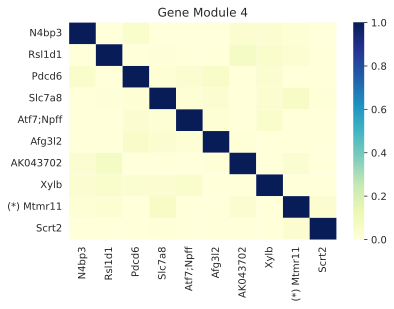

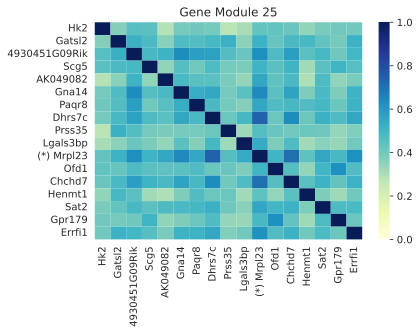

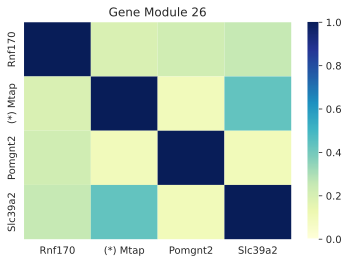

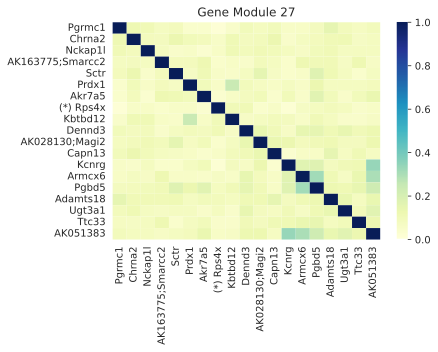

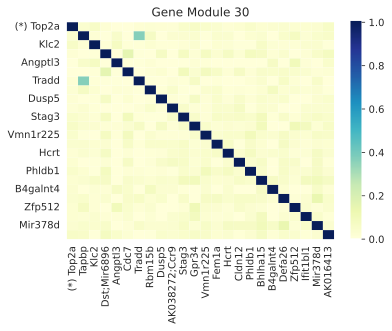

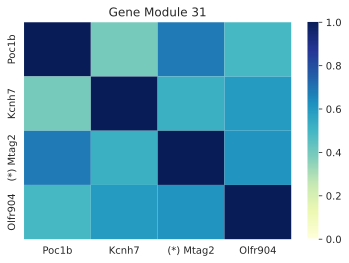

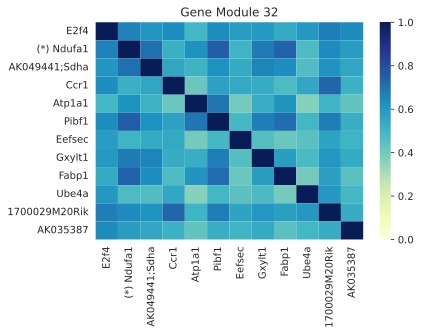

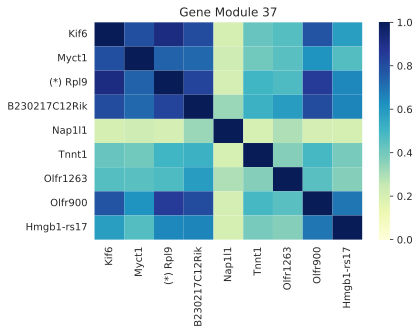

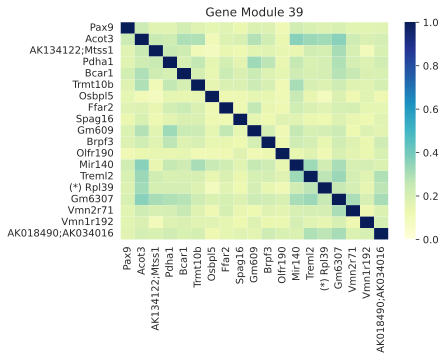

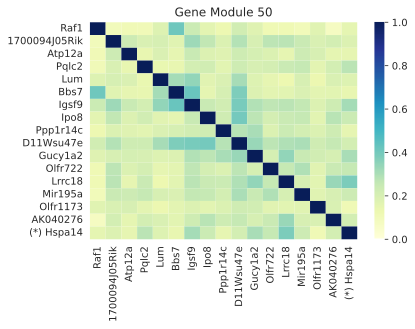

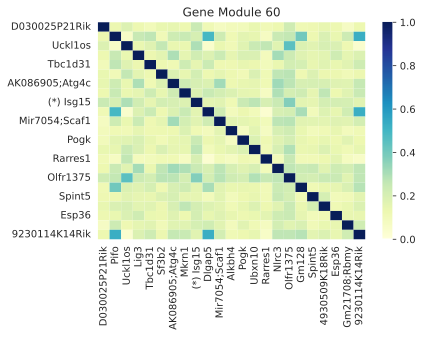

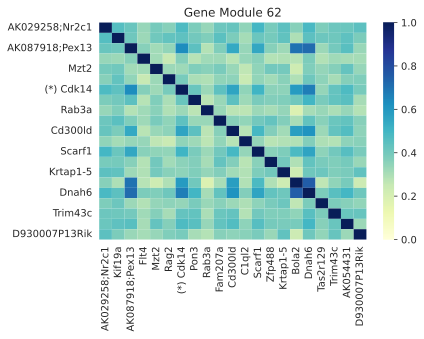

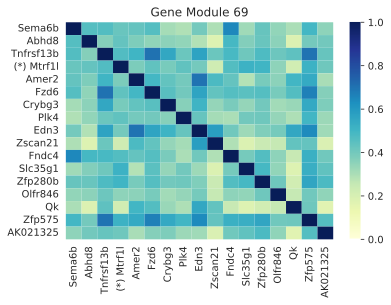

In [25]:
similarity_of_genes = mc.ut.get_vv_frame(clean, 'related_genes_similarity')
for gene_module in suspect_gene_modules:
    module_genes_mask = module_of_genes == gene_module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    similarity_of_module.index = \
    similarity_of_module.columns = [
        '(*) ' + name if name in suspect_gene_names else name
        for name in similarity_of_module.index
    ]
    ax = plt.axes()
    sb.heatmap(similarity_of_module, vmin=0, vmax=1, ax=ax, cmap="YlGnBu")
    ax.set_title(f'Gene Module {gene_module}')
    plt.show()

In [26]:
new_suspect_gene_modules = [25, 26, 30, 31, 32, 37, 62]

In [27]:
forbidden_genes_mask = suspect_genes_mask
for gene_module in new_suspect_gene_modules:
    module_genes_mask = module_of_genes == gene_module
    forbidden_genes_mask |= module_genes_mask
forbidden_gene_names = sorted(clean.var_names[forbidden_genes_mask])
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

341
1700029M20Rik 4930451G09Rik AK016413 AK029258;Nr2c1 AK035387 AK038272;Ccr9 AK049082 AK049441;Sdha AK054431 AK087918;Pex13 Angptl3 Atp1a1 B230217C12Rik B4galnt4 Bex1 Bex2 Bhlha15 Bola2 C1ql2 Ccnb1ip1 Ccnb2 Ccnb3 Ccnc Ccndbp1 Ccne1 Ccne2 Ccng1 Ccng2 Ccnh Ccni Ccnj Ccnjl Ccnk Ccnl2 Ccnt2 Ccny Ccnyl1 Ccr1 Cd300ld Cdc7 Cdk1 Cdk14 Cdk15 Cdk17;Pctk2 Cdk18 Cdk2 Cdk2ap1 Cdk2ap2 Cdk3-ps Cdk5 Cdk5r1 Cdk5rap1 Cdk6 Cdk7 Cdk9 Cdkl2 Cdkn1a Cdkn1b Cdkn1c Cdkn2a Cdkn2c Cdkn2d Cdkn3 Chchd7 Cldn12 D930007P13Rik Defa26 Dhrs7c Dnah6 Dst;Mir6896 Dusp5 E2f4 Eefsec Errfi1 Fabp1 Fam207a Fem1a Flt4 Fos Gatsl2 Gna14 Gpr179 Gpr34 Gxylt1 Hbegf Hcrt Henmt1 Hk2 Hmgb1-rs17 Hsp90aa1 Hsp90ab1 Hspa14 Hspa1b Hspa1l Hspa2 Hspa4l Hspa8 Hspa9 Hspb1 Hspb11 Hspb3 Hspb6 Hspb8 Hspb9 Hspbp1 Hspd1 Hspe1 Hspg2;Mir7018 Hsph1 Ifit1bl1 Isg15 Jun Kcnh7 Kif19a Kif6 Klc2 Krtap1-5 Lgals3bp Mir378d Mrpl11 Mrpl12 Mrpl13 Mrpl14 Mrpl15 Mrpl19 Mrpl22 Mrpl23 Mrpl24 Mrpl32 Mrpl34 Mrpl35 Mrpl36 Mrpl37 Mrpl38 Mrpl4 Mrpl42 Mrpl44 Mrpl45 Mrpl46

In [28]:
max_parallel_piles = mc.pl.guess_max_parallel_piles(clean)
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

482


In [29]:
mc.pl.divide_and_conquer_pipeline(clean,
                                  forbidden_gene_names = forbidden_gene_names,
                                  target_metacell_size = 125000, # ~30 CELLS WITH A MEDIAN UMI OF 4163
                                  random_seed = 123456)

set clean.var[rare_gene]: 0 true (0%) out of 15747 bools
set clean.var[rare_gene_module]: 15747 int32 elements with all outliers (100%)
set clean.obs[cells_rare_gene_module]: 191249 int32 elements with all outliers (100%)
set clean.obs[rare_cell]: 0 true (0%) out of 191249 bools
set clean.uns[pre_directs]: 7
set clean.uns[directs]: 9
set clean.var[pre_high_total_gene]: 6434 positive (40.86%) out of 15747 int32s
set clean.var[high_total_gene]: 7025 positive (44.61%) out of 15747 int32s
set clean.var[pre_high_relative_variance_gene]: 5136 positive (32.62%) out of 15747 int32s
set clean.var[high_relative_variance_gene]: 5935 positive (37.69%) out of 15747 int32s
set clean.var[forbidden_gene]: 341 true (2.165%) out of 15747 bools
set clean.var[pre_feature_gene]: 473 positive (3.004%) out of 15747 int32s
set clean.var[feature_gene]: 607 positive (3.855%) out of 15747 int32s
set clean.var[pre_gene_deviant_votes]: 318 positive (2.019%) out of 15747 int32s
set clean.var[gene_deviant_votes]: 28

In [30]:
metacells = mc.pl.collect_metacells(clean, name='iETX.metacells')

set iETX.metacells.var[excluded_gene]: 0 true (0%) out of 15747 bools
set iETX.metacells.var[clean_gene]: 15747 true (100%) out of 15747 bools
set iETX.metacells.var[forbidden_gene]: 341 true (2.165%) out of 15747 bools
set iETX.metacells.var[pre_feature_gene]: 473 positive (3.004%) out of 15747 int32s
set iETX.metacells.var[feature_gene]: 607 positive (3.855%) out of 15747 int32s
set iETX.metacells.obs[pile]: 449 int32s
set iETX.metacells.obs[candidate]: 449 int32s


set iETX.metacells.var[top_feature_gene]: 607 true (3.855%) out of 15747 bools
set iETX.metacells.obsp[obs_balanced_ranks]: 5420 nonzero (2.688%) out of 201601 elements
set iETX.metacells.obsp[obs_pruned_ranks]: 1793 nonzero (0.8894%) out of 201601 elements
set iETX.metacells.obsp[obs_outgoing_weights]: 1793 nonzero (0.8894%) out of 201601 elements
set iETX.metacells.obsp[umap_distances]: csr_matrix 449 X 449 float32s (201152 > 0)
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set iETX.metacells.obs[umap_x]: 449 float32s
set iETX.metacells.obs[umap_y]: 449 float32s


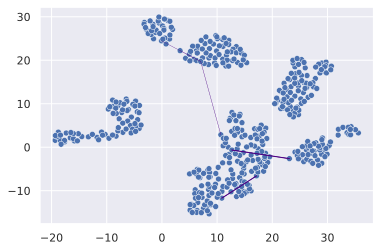

In [31]:
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=2.0, random_seed=123456) # INCREASE min_dist TO GET COMPACTION

umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')

umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, 'obs_outgoing_weights'))
min_long_edge_size = 4
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y)
for (source_index, target_index, weight) \
        in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

In [32]:
outliers = mc.pl.compute_for_mcview(adata=clean, gdata=metacells, 
                                    random_seed=123456, 
                                    compute_var_var_similarity=dict(top=50, bottom=50))

set iETX.metacells.var[significant_gene]: 5482 true (34.81%) out of 15747 bools
set iETX.metacells.var[top_feature_gene]: 607 true (3.855%) out of 15747 bools
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
set iETX.metacells.obsp[obs_balanced_ranks]: 5420 nonzero (2.688%) out of 201601 elements
set iETX.metacells.obsp[obs_pruned_ranks]: 1793 nonzero (0.8894%) out of 201601 elements
set iETX.metacells.obsp[obs_outgoing_weights]: 1793 nonzero (0.8894%) out of 201601 elements
set iETX.metacells.obsp[umap_distances]: csr_matrix 449 X 449 float32s (201152 > 0)
/home/ofirr/anaconda3/envs/amosbase/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set iETX.metacells.obs[um

In [33]:
clean.var.index.name = "gene"

In [34]:
clean.write('/net/mraid14/export/tgdata/users/hernan/wd_NEW/SynEmbs3/Submission/scrna_db/mat.iETX3.h5ad')

In [35]:
metacells.var.index.name = "gene"

In [36]:
metacells.write('/net/mraid14/export/tgdata/users/hernan/wd_NEW/SynEmbs3/Submission/scrna_db/mc.iETX3.h5ad')